In [1]:
from qiskit import *
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())


In [17]:
#DEFINE (PIETRO'S) MATRIX

alpha = 2

import numpy as np
def k(theta, alpha):
    return np.sqrt((-1+2*alpha**2 + np.cosh(theta))/(-1+np.cosh(theta)))


def U(theta, alpha):
    
    return np.array([[(1-2*1j*alpha*(1/np.sinh(theta)))/(k(theta,alpha)), 0, 0, (-1j*alpha*(1/np.cosh(theta/2)))/(k(theta,alpha))],
                     
                     [0, ((-4*1j*alpha*(np.cos(0.25*(np.pi+1j*theta)))**2)*(1/np.sinh(theta)))/(k(theta,alpha)),
                      (2*(np.cos(0.25*(np.pi+1j*theta)))**2)*(1/np.cosh(theta/2))/(k(theta,alpha)),0],
                     
                    [0,(2*(1/np.cosh(theta/2))*(np.sin(0.25*(np.pi+1j*theta)))**2)/(k(theta,alpha)),
                     ((-4*1j*alpha*(np.sin(0.25*(np.pi+1j*theta)))**2)*(1/np.sinh(theta)))/(k(theta,alpha)),0],
                     
                    [(1j*alpha*(1/np.cosh(theta/2)))/(k(theta,alpha)),0,0,(-1-2*1j*alpha*(1/np.sinh(theta)))/(k(theta,alpha))]])



AnalysisResult
- name: state
- value: DensityMatrix([[ 8.73333333e-01+0.j        ,  1.56666667e-02-0.00658333j,
                 1.79166667e-02-0.01675j   , -9.25000000e-03-0.0055j    ],
               [ 1.56666667e-02+0.00658333j,  3.30000000e-02+0.j        ,
                 1.02500000e-02-0.006j     , -3.08333333e-03-0.00525j   ],
               [ 1.79166667e-02+0.01675j   ,  1.02500000e-02+0.006j     ,
                 2.85000000e-02+0.j        , -3.33333333e-04+0.00291667j],
               [-9.25000000e-03+0.0055j    , -3.08333333e-03+0.00525j   ,
                -3.33333333e-04-0.00291667j,  6.51666667e-02+0.j        ]],
              dims=(2, 2))
- extra: <5 items>
- device_components: ['Q0', 'Q1']
- verified: False
AnalysisResult
- name: positive
- value: True
- device_components: ['Q0', 'Q1']
- verified: False
(0.8733333333333334+0j)


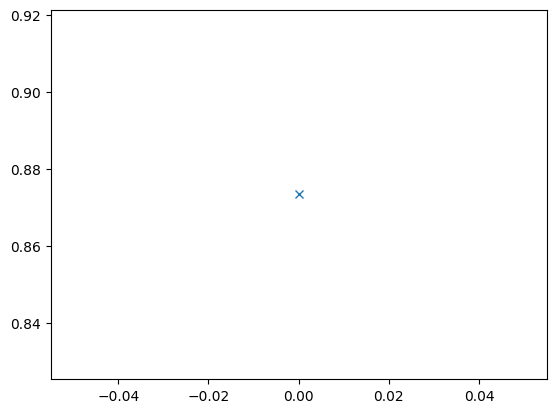

In [22]:
theta0=0.001
theta = 0.5
alpha=2


#build circuit    
qc = QuantumCircuit(2,2)
v0=np.array([1,0,0,0])
init = U(theta0,alpha)@v0
init = init.tolist()
QuantumCircuit.initialize(qc,init,[0,1])
matrix = U(theta,alpha)
qc.unitary(matrix, [0,1])
qc.barrier(range(2))
qc.measure(range(2),range(2))

# QST Experiment
qstexp1 = StateTomography(qc)
qstdata1 = qstexp1.run(backend, shots=2000, seed_simulation=100).block_for_results()

# Print results
for result in qstdata1.analysis_results():
    print(result)

#fitted state extraction
final_state = qstdata1.analysis_results("state")
density=np.asarray(final_state.value)
print(density[0,0])
#A.append(density([0,0]))
plt.plot(density[0,0],'x')

In [8]:
#variables
theta0 = 0.001   #initial theta
theta1 = 5 
theta=0.6
#final theta
alpha = 2
shots = 24000
#res = 0.1
res_list = np.array([0.005])

#plotting specs
#color = iter(cm.rainbow(np.linspace(0, 1, len(res_list))))
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
#plt.tick_params(labelsize=10) vccf

m = 0


for res in res_list:  
    A = []
    B = []
    #c = next(color)
    theta_sweep=np.arange(theta0, theta1, res) 
    
    #initialize first time
    qc = QuantumCircuit(2,2)
    v0=np.array([1,0,0,0])
    v1 = np.zeros(4)
    init = U(theta0,alpha)@v0
    init = init.tolist()
    QuantumCircuit.initialize(qc,init,[0,1])
    
    for a, theta in enumerate(tqdm(theta_sweep)):    
        
        print(theta)        
        #build circuit    
        
        matrix = U(theta,alpha)
        qc.unitary(matrix, [0,1])
        qc.barrier(range(2))
        qc.measure(range(2),range(2))
        
        # QST Experiment
        
        qstexp1 = StateTomography(qc)
        #qstexp1.analysis.set_options(fitter='cvxpy_gaussian_lstsq')
        qstdata1 = qstexp1.run(backend,shots=shots, seed_simulation=100).block_for_results()
        
        
        # Print results
        #for result in qstdata1.analysis_results():
        #    print(result)
        #    print(result.extra)
        
        #fitted state extraction
        final_state = qstdata1.analysis_results("state")
        density=np.asarray(final_state.value)
        
        #save state value for plotting 
        A.append(np.abs(density[0,0]))
        B.append(np.abs(density[3,3]))
        
        #NOT SO LEGIT: here I convert density to DensityMatrix object and then to a statevector
        density = DensityMatrix(density)
        new_init = density.to_statevector(atol=1E-1)
              
        #store in classical bit (still to implement, now we just put it in list)
        
        ##re-initialise state to previous iteration tomography fit for statevector and enter next stage 
        #for i in range(len(v1)):
        #    v1[i]=density[i,i]

        #    v1[0]+=np.sqrt(o)
        #print('amplitude-squared sum is')
        #print(sum(v1[i] for i in range(len(v1)))) 
        
        #raise KeyboardInterrupt
        #here we have to renormalize v1 as its squared amplitudes sum to something like 1.00000000000008 instead of 1 and 
        #init doesnt want to initialise to some nonunitary
       # print(np.dot(v1.conj().T,v1))
        #raise KeyboardInterrupt
        QuantumCircuit.initialize(qc,new_init,[0,1])
        
            
    
    A = np.asarray(A)
    B = np.asarray(B)
    plt.plot(theta_sweep, A)
    plt.plot(theta_sweep, B)
    plt.xlabel(r'$\theta$')
    plt.ylabel('Amplitude')
    plt.title('Tomography - resolution '+str(res)+', shots = '+str(shots))
    plt.savefig('/home/alberto/Notebooks/Tomography - resolution '+str(res)+', shots = '+str(shots)+'.pdf')
    
#    #print(len(B[0]))
#    C = np.zeros(len(B))
#    for i in range(len(B)):
#        #print(B[i,:])
#        C[i] = np.average(B[i,:])
#    plt.plot(theta_sweep, C+m,'-', c=c)
#    plt.xlabel(r'$\theta$')
#    plt.ylabel('Amplitude')
#    #plt.title('Time evolution for different Trotter step sizes')
#    m += 1
#
##plt.savefig('C:\Users\azorzat\Desktop\Coding\Notebooks\Plots\swag.pdf')
#

  0%|                                                                                          | 0/1000 [00:00<?, ?it/s]

0.001


  0%|                                                                                  | 1/1000 [00:02<33:45,  2.03s/it]

0.006


  0%|▏                                                                                 | 2/1000 [00:05<49:26,  2.97s/it]

0.011


  0%|▏                                                                                 | 3/1000 [00:09<57:58,  3.49s/it]

0.016


  0%|▎                                                                               | 4/1000 [00:14<1:08:09,  4.11s/it]

0.021


  0%|▍                                                                               | 5/1000 [00:20<1:19:06,  4.77s/it]

0.026000000000000002


  1%|▍                                                                               | 6/1000 [00:27<1:31:16,  5.51s/it]

0.031


  1%|▌                                                                               | 7/1000 [00:35<1:43:33,  6.26s/it]

0.036000000000000004


  1%|▋                                                                               | 8/1000 [00:44<1:59:59,  7.26s/it]

0.041


  1%|▋                                                                               | 9/1000 [00:55<2:19:08,  8.42s/it]

0.046


  1%|▊                                                                              | 10/1000 [01:07<2:36:29,  9.48s/it]

0.051000000000000004


  1%|▊                                                                              | 11/1000 [01:20<2:54:39, 10.60s/it]

0.056


  1%|▉                                                                              | 12/1000 [01:35<3:12:41, 11.70s/it]

0.061


  1%|█                                                                              | 13/1000 [01:50<3:30:44, 12.81s/it]

0.066


  1%|█                                                                              | 14/1000 [02:06<3:47:01, 13.82s/it]

0.07100000000000001


  2%|█▏                                                                             | 15/1000 [02:24<4:05:08, 14.93s/it]

0.076


  2%|█▎                                                                             | 16/1000 [02:42<4:24:21, 16.12s/it]

0.081


  2%|█▎                                                                             | 17/1000 [03:02<4:42:55, 17.27s/it]

0.08600000000000001


  2%|█▍                                                                             | 18/1000 [03:23<5:00:02, 18.33s/it]

0.091


  2%|█▌                                                                             | 19/1000 [03:45<5:15:25, 19.29s/it]

0.096


  2%|█▌                                                                             | 20/1000 [04:08<5:33:49, 20.44s/it]

0.101


  2%|█▋                                                                             | 21/1000 [04:32<5:49:36, 21.43s/it]

0.106


  2%|█▋                                                                             | 22/1000 [04:56<6:05:21, 22.41s/it]

0.111


  2%|█▊                                                                             | 23/1000 [05:22<6:21:53, 23.45s/it]

0.116


  2%|█▉                                                                             | 24/1000 [05:49<6:38:45, 24.51s/it]

0.121


  2%|█▉                                                                             | 25/1000 [06:17<6:54:43, 25.52s/it]

0.126


  3%|██                                                                             | 26/1000 [06:46<7:11:38, 26.59s/it]

0.131


  3%|██▏                                                                            | 27/1000 [07:17<7:31:49, 27.86s/it]

0.136


  3%|██▏                                                                            | 28/1000 [07:50<7:58:21, 29.53s/it]

0.14100000000000001


  3%|██▎                                                                            | 29/1000 [08:26<8:29:25, 31.48s/it]

0.146


  3%|██▎                                                                            | 30/1000 [09:01<8:42:06, 32.30s/it]

0.151


  3%|██▍                                                                            | 31/1000 [09:35<8:53:39, 33.04s/it]

0.156


  3%|██▌                                                                            | 32/1000 [10:11<9:05:22, 33.80s/it]

0.161


  3%|██▌                                                                            | 33/1000 [10:48<9:21:24, 34.83s/it]

0.166


  3%|██▋                                                                            | 34/1000 [11:26<9:34:39, 35.69s/it]

0.171


  4%|██▋                                                                           | 35/1000 [12:08<10:02:39, 37.47s/it]

0.17600000000000002


  4%|██▊                                                                           | 36/1000 [12:53<10:39:08, 39.78s/it]

0.181


  4%|██▉                                                                           | 37/1000 [13:40<11:14:46, 42.04s/it]

0.186


  4%|██▉                                                                           | 38/1000 [14:24<11:22:55, 42.59s/it]

0.191


  4%|███                                                                           | 39/1000 [15:08<11:30:09, 43.09s/it]

0.196


  4%|███                                                                           | 40/1000 [15:55<11:47:51, 44.24s/it]

0.201


  4%|███▏                                                                          | 41/1000 [16:42<11:57:46, 44.91s/it]

0.20600000000000002


  4%|███▎                                                                          | 42/1000 [17:28<12:06:37, 45.51s/it]

0.211


  4%|███▎                                                                          | 43/1000 [18:16<12:17:41, 46.25s/it]

0.216


  4%|███▍                                                                          | 44/1000 [19:11<12:55:22, 48.66s/it]

0.221


  4%|███▌                                                                          | 45/1000 [20:03<13:10:18, 49.65s/it]

0.226


  5%|███▌                                                                          | 46/1000 [20:56<13:24:31, 50.60s/it]

0.231


  5%|███▋                                                                          | 47/1000 [21:49<13:36:05, 51.38s/it]

0.23600000000000002


  5%|███▋                                                                          | 48/1000 [22:44<13:53:30, 52.53s/it]

0.241


  5%|███▊                                                                          | 49/1000 [23:39<14:03:59, 53.25s/it]

0.246


  5%|███▉                                                                          | 50/1000 [24:39<14:34:09, 55.21s/it]

0.251


  5%|███▉                                                                          | 51/1000 [25:36<14:42:56, 55.82s/it]

0.256


  5%|████                                                                          | 52/1000 [26:33<14:49:11, 56.28s/it]

0.261


  5%|████▏                                                                         | 53/1000 [27:32<14:58:57, 56.96s/it]

0.266


  5%|████▏                                                                         | 54/1000 [28:33<15:20:21, 58.37s/it]

0.271


  6%|████▎                                                                         | 55/1000 [29:35<15:36:31, 59.46s/it]

0.276


  6%|████▎                                                                         | 56/1000 [30:37<15:47:33, 60.23s/it]

0.281


  6%|████▍                                                                         | 57/1000 [31:39<15:52:55, 60.63s/it]

0.28600000000000003


  6%|████▌                                                                         | 58/1000 [32:41<15:59:13, 61.10s/it]

0.291


  6%|████▌                                                                         | 59/1000 [33:47<16:18:14, 62.37s/it]

0.296


  6%|████▋                                                                         | 60/1000 [34:57<16:53:44, 64.71s/it]

0.301


  6%|████▊                                                                         | 61/1000 [36:08<17:23:13, 66.66s/it]

0.306


  6%|████▊                                                                         | 62/1000 [37:20<17:48:26, 68.34s/it]

0.311


  6%|████▉                                                                         | 63/1000 [38:33<18:09:18, 69.75s/it]

0.316


  6%|████▉                                                                         | 64/1000 [39:48<18:30:26, 71.18s/it]

0.321


  6%|█████                                                                         | 65/1000 [41:04<18:54:06, 72.78s/it]

0.326


  7%|█████▏                                                                        | 66/1000 [42:22<19:14:03, 74.14s/it]

0.331


  7%|█████▏                                                                        | 67/1000 [43:39<19:27:07, 75.06s/it]

0.336


  7%|█████▎                                                                        | 68/1000 [44:59<19:49:27, 76.57s/it]

0.341


  7%|█████▍                                                                        | 69/1000 [46:23<20:22:47, 78.80s/it]

0.34600000000000003


  7%|█████▍                                                                        | 70/1000 [47:55<21:24:11, 82.85s/it]

0.35100000000000003


  7%|█████▌                                                                        | 71/1000 [49:25<21:56:49, 85.05s/it]

0.356


  7%|█████▌                                                                        | 72/1000 [51:00<22:41:11, 88.01s/it]

0.361


  7%|█████▋                                                                        | 73/1000 [52:30<22:48:34, 88.58s/it]

0.366


  7%|█████▊                                                                        | 74/1000 [54:01<22:56:29, 89.19s/it]

0.371


  8%|█████▊                                                                        | 75/1000 [55:37<23:27:40, 91.31s/it]

0.376


  8%|█████▉                                                                        | 76/1000 [57:14<23:51:21, 92.95s/it]

0.381


  8%|██████                                                                        | 77/1000 [58:56<24:30:10, 95.57s/it]

0.386


  8%|█████▊                                                                     | 78/1000 [1:00:48<25:44:48, 100.53s/it]

0.391


  8%|█████▉                                                                     | 79/1000 [1:02:41<26:44:14, 104.51s/it]

0.396


  8%|██████                                                                     | 80/1000 [1:04:32<27:08:56, 106.24s/it]

0.401


  8%|██████                                                                     | 81/1000 [1:06:21<27:21:00, 107.14s/it]

0.406


  8%|██████▏                                                                    | 82/1000 [1:08:07<27:14:20, 106.82s/it]

0.41100000000000003


  8%|██████▏                                                                    | 83/1000 [1:10:01<27:44:22, 108.90s/it]

0.41600000000000004


  8%|██████▎                                                                     | 83/1000 [1:11:55<13:14:37, 51.99s/it]


QiskitError: 'Density matrix is not a pure state'

In [ ]:
#PROBLEMA E CHIEDERSI SE AD OGNI ITERAZIONE STA AGENDO SULLO STATEVECTOR RISULTANTE DALLA COMPUTAZIONE PRECEDENTE
#O ALTRO

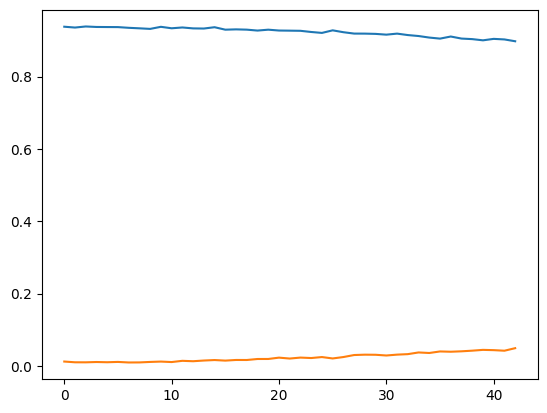

In [5]:
v = np.zeros(80)

for i in range(80):
    v[i]+=0.005
        

A = np.asarray(A)
B = np.asarray(B)
plt.plot(A)
plt.plot(B)

Text(0, 0.5, 'Amplitude')

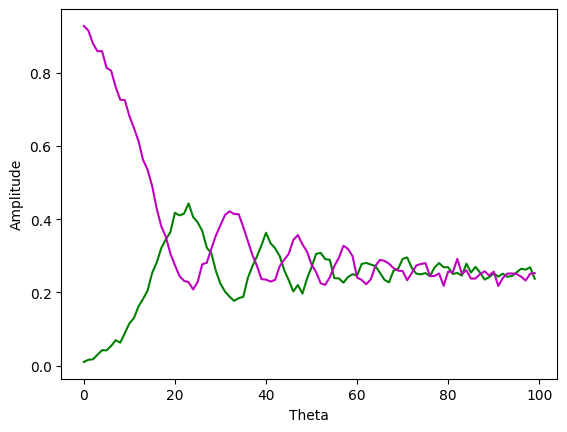

In [13]:
import pickle
  
# Open the file in binary mode
with open('Evolution 00 - Trotter step=0.005, shots=1000 .pkl', 'rb') as file:
      
    # Call load method to deserialze
    vec_00 = pickle.load(file)

  
# Open the file in binary mode
with open('Evolution 11 - Trotter step=0.005, shots=1000 .pkl', 'rb') as file:
      
    # Call load method to deserialze
    vec_11 = pickle.load(file)
    
    
    
plt.plot(vec_11[:100], c='g')
plt.plot(vec_00[:100], c='m')
plt.xlabel('Theta')
plt.ylabel('Amplitude')